In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Data Generation

In [2]:
import dataloader as dl

# dataSource
td, tl, pd, pl = dl.read_bci_data()
pd.shape    # numbers of shape represent (N, C, H, W)/(batch size, channels, height, weight)
# td.len  # batch size

(1080, 1, 2, 750)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

trainset = TensorDataset(torch.from_numpy(td), torch.from_numpy(tl))
# trainset.tensors[0].shape

trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)
trainloader.dataset.tensors[0].shape

torch.Size([1080, 1, 2, 750])

### Model Training

#### Neural Network 訓練步驟
1. 訓練Model
1. 計算Loss (MSE、CrossEntropy)
1. 最佳化Model (Optimization)

In [3]:
class EEGNET(nn.Module):
  def __init__(self, actFun) -> None:
    super(EEGNET, self).__init__()
    match actFun:
      case "ELU":
        self.activation = nn.ELU(alpha=1.0)
      case "ReLU":
        self.activation = nn.ReLU()
      case "LeakyReLU":
        self.activation = nn.LeakyReLU()

    # Layer 1
    self.FirstConv = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
      , nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )

    # Layer 2
    self.DepthWiseConv = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
      , nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      , nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      , self.activation
      , nn.Dropout(p=0.25)
    )

    # Layer 3
    self.SeperableConv = nn.Sequential(
      nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
      , nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      , self.activation
      , nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
      , nn.Dropout(p=0.25)
    )

    self.Classify = nn.Sequential(
      nn.Linear(in_features=736, out_features=2, bias=True)
    )

  def forward(self, x):  # 直接寫model(input)就等於call forward這個函數了
    x = self.FirstConv(x)
    x = self.DepthWiseConv(x)
    x = self.SeperableConv(x) # x.shape = (1080, 32, 1, 23)

    x = x.view(-1, 736) # reshape to fit the classifier (-1部分讓python自己推測)
    x = self.Classify(x)

    return x

# EEGNET model架構
# model = EEGNET("ELU")
# print(model)

In [4]:
class DeepConvNet(nn.Module):
    def __init__(self, actFun) -> None:
        super(DeepConvNet, self).__init__()
        match actFun:
            case "ELU":
                self.activation = nn.ELU(alpha=1.0)
            case "ReLU":
                self.activation = nn.ReLU()
            case "LeakyReLU":
                self.activation = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 2))
        self.dropout = nn.Dropout(p=0.5)

        # Layer
        self.conv1 = nn.Conv2d(1, 25, kernel_size=(1, 5), bias=False)
        self.conv2 = nn.Conv2d(25, 25, kernel_size=(2, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(25, eps=1e-05, momentum=0.1)
        
        self.conv3 = nn.Conv2d(25, 50, kernel_size=(1, 5), bias=False)
        self.bn2 = nn.BatchNorm2d(50, eps=1e-05, momentum=0.1)

        self.conv4 = nn.Conv2d(50, 100, kernel_size=(1, 5), bias=False)
        self.bn3 = nn.BatchNorm2d(100, eps=1e-05, momentum=0.1)

        self.conv5 = nn.Conv2d(100, 200, kernel_size=(1, 5), bias=False)
        self.bn4 = nn.BatchNorm2d(200, eps=1e-05, momentum=0.1)

        self.classifier = nn.Linear(200*43, 2, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = self.maxpool(x) # x.shape = (1080, 200, 1, 43)
        x = self.dropout(x)

        x = x.view(-1, 200*43)
        x = self.classifier(x)
        
        return x

##### Note
* model相關
    * **model只做forwrad**
    * model可以呼叫`model.train()`來將model變成訓練模式；呼叫`model.eval()`則會變成預測模式
    * model繼承nn.Module後可以直接用`model(input)`來執行forward，但記得自己的model中還是需要有forward這個函數
    * model預設的輸入值是double，可以藉由`model.float()`更換model parameter型態
* loss function相關
    * **loss負責做backword(計算gradient)**
    * `nn.CrossEntropyLoss(output, target)` -> target型態必須是Long
    * `loss.item()`就是loss的值
* optimizer相關
    * **optimizer負責update weights -> `optimizer.step()`**
    * 在新的forward開始之前要先把之前的gradient清掉 -> optimizer.zero_grad()

In [17]:
class Model:
    def __init__(self, model, batch_size, learning_rate, epochs) -> None:
        self.model = model.double()
        self.batch_size = batch_size
        self.isIndivisible = 0 # 需不需要隨機取資料填補最後一個batch
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def Train(self, train_data, train_label):
        # train mode(告訴model現在要開始訓練了)
        self.model.train()
        self.isIndivisible = 1*(len(train_data) % self.batch_size > 0) # 如果data量不是batch size的倍數，最後的batch資料會比較少
        times = len(train_data)//self.batch_size + self.isIndivisible  # 一個epoch中會有多少個batch
        train_accs = []
        train_losses = []
        test_accs = []

        for ep in range(self.epochs):
            correct = 0.0
            cost = 0.0

            for i in range(times):
                if self.isIndivisible and i==times-1:
                    input = torch.from_numpy(train_data[i*self.batch_size:]).double()
                    label = torch.from_numpy(train_label[i*self.batch_size:])
                else:
                    input = torch.from_numpy(train_data[i*self.batch_size:(i+1)*self.batch_size-1]).double()
                    label = torch.from_numpy(train_label[i*self.batch_size:(i+1)*self.batch_size-1])
                self.optimizer.zero_grad()  # 清空上次的gradient

                output = self.model(input)    # forwarding
                loss = self.loss_function(output, label.long())    # nn.CrossEntropyLoss(predict_val, label)
                loss.backward() # calculating gradient

                self.optimizer.step()   # updating weights

                # calculating corrects and costs
                pred_val = output.argmax(dim=1)
                correct += (pred_val == label).sum()
                cost += loss.item()

            train_accs.append((100*correct / len(train_data)).item())
            train_losses.append(cost / times)  # 一個epoch的loss通常為epoch中計算出來的所有loss的平均
            print("Epoch {}/{} acc: {} loss: {}".format(ep+1, self.epochs, train_accs[ep], train_losses[ep]))

            # predicting
            test_accs.append(self.Predict(train_data, train_label))
        return train_accs, train_losses, test_accs

    def Save(self, filepath):
        torch.save(self.model, filepath)

    def Predict(self, test_data, test_label):
        # evaluate mode (告訴model現在要開始預測了)
        self.model.eval()
        
        correct = 0.0
        input = torch.from_numpy(test_data).double()
        label = torch.from_numpy(test_label)

        output = self.model(input)    # predicting
        pred_val = output.argmax(dim=1)
        correct += (pred_val == label).sum()
        return (100*correct / len(test_data)).item()

In [26]:
def Plot(usedModelName, epochs, accs, losses):
    # constant
    ylabel = ["Accuracy(%)", "Loss"]
    labels = ["relu_train", "relu_test", "leaky_relu_train", "leaky_relu_test", "elu_train", "elu_test"]
    colors = ["tab:olive", "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(12)
    plt.suptitle("Activation Function Comparision ({})".format(usedModelName))

    for i in range(len(labels)):
            ax[0].plot(np.arange(epochs), accs[i], color=colors[i], label=labels[i])
            ax[1].plot(np.arange(epochs), losses[i], color=colors[i], label=labels[i])

    for subp in range(2):
        plt.setp(ax[subp], xlabel="Epoch", ylabel=ylabel[subp])
        ax[subp].legend(loc='lower right')
        
    plt.tight_layout()
    plt.show()

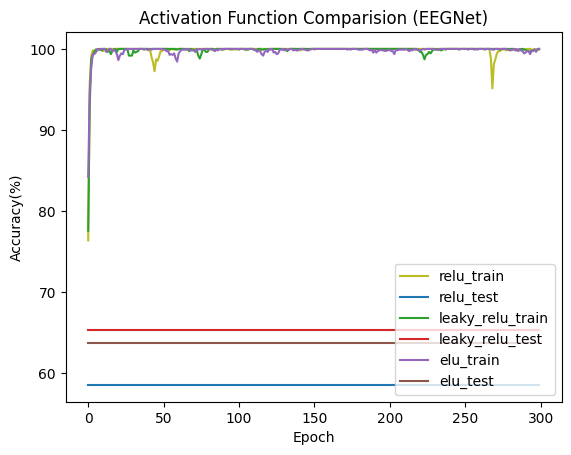

In [72]:
# hyperparameters
batch_size = 64
learning_rate = 1e-2
epochs = 300
activation_funs = ["ReLU", "LeakyReLU", "ELU"]
accs = []
losses = []
models = []

for i in range(len(activation_funs)):
    print("EEGNet with {}".format(activation_funs[i]))
    models.append(Model(EEGNET(activation_funs[i]), batch_size, learning_rate, epochs))

    train_acc, train_loss, test_acc = models[i].Train(td, tl)
    accs.append(train_acc)
    accs.append(test_acc)
    losses.append(train_loss)
    losses.append([0 for i in range(len(train_loss))])

Plot("EEGNet", epochs, accs, losses)

DeepConvNet with ReLU
Epoch 1/5 acc: 50.83333206176758 loss: 9.240693064844669
Epoch 2/5 acc: 49.907405853271484 loss: 11.494893966899143
Epoch 3/5 acc: 55.092594146728516 loss: 0.6972013881705503
Epoch 4/5 acc: 55.64814758300781 loss: 0.6716711337584917
Epoch 5/5 acc: 61.66666793823242 loss: 0.6396863552416416
DeepConvNet with LeakyReLU
Epoch 1/5 acc: 49.53703689575195 loss: 6.290792951477425
Epoch 2/5 acc: 51.38888931274414 loss: 8.99258965841071
Epoch 3/5 acc: 48.425926208496094 loss: 0.7138265276560491
Epoch 4/5 acc: 57.5 loss: 0.6818323917225666
Epoch 5/5 acc: 62.87036895751953 loss: 0.6473862538575177
DeepConvNet with ELU
Epoch 1/5 acc: 60.185184478759766 loss: 6.452607181939497
Epoch 2/5 acc: 61.01852035522461 loss: 11.600031215893978
Epoch 3/5 acc: 59.62963104248047 loss: 5.061339081777738
Epoch 4/5 acc: 59.814815521240234 loss: 3.3361412268824555
Epoch 5/5 acc: 63.98147964477539 loss: 0.9912774175654725


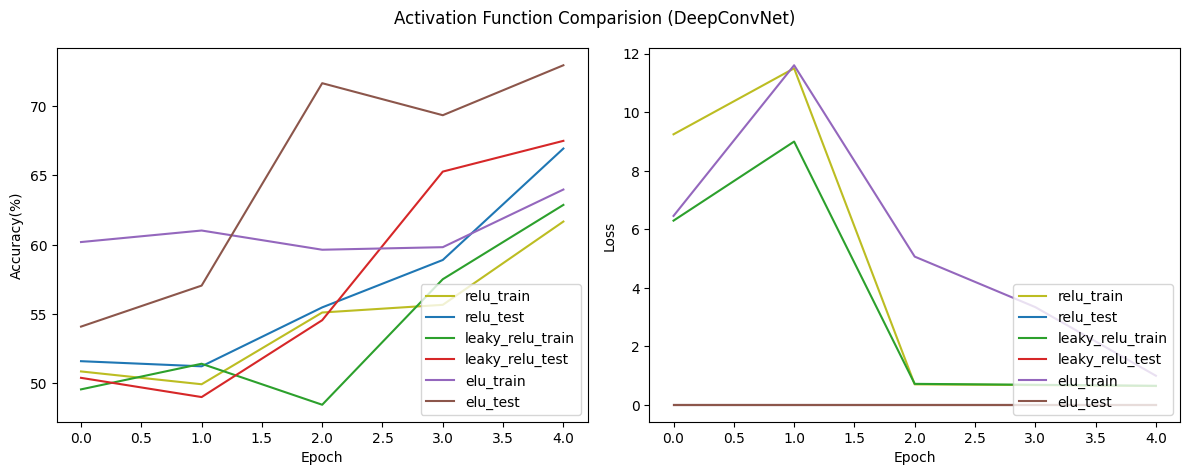

In [27]:
# hyperparameters
batch_size = 64
learning_rate = 1e-2
epochs = 5
activation_funs = ["ReLU", "LeakyReLU", "ELU"]
accs = []
losses = []
models = []

for i in range(len(activation_funs)):
    print("DeepConvNet with {}".format(activation_funs[i]))
    models.append(Model(DeepConvNet(activation_funs[i]), batch_size, learning_rate, epochs))
    
    train_acc, train_loss, test_acc = models[i].Train(td, tl)
    accs.append(train_acc)
    accs.append(test_acc)
    losses.append(train_loss)
    losses.append([0 for i in range(len(train_loss))])

Plot("DeepConvNet", epochs, accs, losses)

In [ ]:
a = torch.tensor([[0.7,-0.3],[0.5,-0.6]])
l = torch.tensor([1,0])
# a = torch.tensor([i.sum() for i in a])
# b = ((a>0)==l).sum()
# b.item()
for v in zip(a, l):
    print(v)

In [ ]:
arr = np.arange(10)
b = 4
lack = len(arr) % b
trained, untrained = arr[:-lack-1], arr[-lack-1:-1]
np.random.shuffle(trained)

res = untrained
res = np.append(res, trained[:lack])
res

array([7, 8, 5, 1])

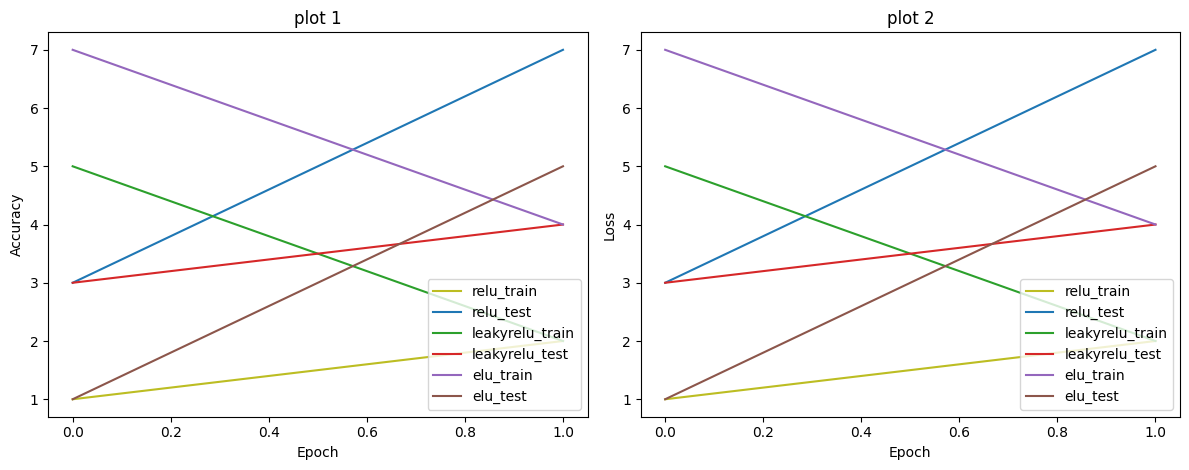

In [23]:
xs = ["relu_train", "relu_test", "leakyrelu_train", "leakyrelu_test", "elu_train", "elu_test"]
ys = [[1, 2], [3, 7], [5, 2], [3, 4], [7, 4], [1, 5]]
zs = ["tab:olive", "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown"]
ylabel = ["Accuracy", "Loss"]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
for j in range(2):
    plt.setp(ax[j], title="plot {}".format(j+1), xlabel="Epoch", ylabel=ylabel[j])
    
    for i in range(len(xs)):
        ax[j].plot(np.arange(2), ys[i], color=zs[i], label=xs[i])

    ax[j].legend(loc='lower right')
plt.tight_layout()
plt.show()